# Sandbox for Beginners

In this notebook, we will dive into Sandbox, a comprehensive suite in Data-Juicer for data-model co-development. With Sandbox, users can experiment, iterate and refine data recipes and datasets based on some small-scale models and datasets to obtain some data processing inghts with low overhead. These insights then can be transfered to large scale to produce high-quality and high-performance models and datsets.

In Sandbox, users can use various configurable components from Data-Juicer, such as analysis and probe tools and data processing pipelines, and other open-source tools or architectures, such as model training and evalution metrics, to construct a data-model feedback loop for one-stop data recipe refinement.

For more details, please refer to the [Sandbox doc]https://github.com/modelscope/data-juicer/blob/main/docs/Sandbox.md().

Now let's begin to use sandbox to refine a initial data recipe in a simple example.

## Prepare Config Files for Sandbox

The default one-trial pipeline of Sandbox including 4 types of jobs. Each type of jobs corresponds to a config group with one or more hooks and their config files. So there are also 4 types of config groups:
- Data/Model Probe -- `probe_job_configs`
- Iterative Recipe Refinement based on Probe Results -- `refine_recipe_job_configs`
- Dataset Processing and Model Training -- `execution_job_configs`
- Data/Model Evaluation -- `evaluation_job_configs`

In each config group, various hooks can be mounted and are organized as configurable job list. For each hook, we need to specify:
- hook name -- `hook`
- tag name for recording intermediate results -- `meta_name`
- Data-Juicer recipe config for some Data-Juicer components -- `dj_config`
- some specific parameters for this hook -- `extra_configs`

Here we take a typical data recipe refinement using the k-sigma method pipeline as the example. The sandbox config file could be:
```yaml
# global parameters
project_name: 'sandbox-recipe-refinement'
experiment_name: 'sandbox-recipe-refinement-run0' # for wandb tracer name
work_dir: './outputs/sandbox-process/'
hpo_config: null                                  # path to a configuration file when using auto-HPO tool.

# configs for each job, the jobs will be executed according to the order in the list
probe_job_configs:
  - hook: 'ProbeViaAnalyzerHook'
    meta_name: 'analysis_ori_data'
    dj_configs: 'dj_process.yaml'
    extra_configs:

refine_recipe_job_configs:
  - hook: 'RefineRecipeViaKSigmaHook'
    meta_name: 'analysis_ori_data'
    dj_configs: 'dj_process.yaml'
    extra_configs:
      path_k_sigma_recipe: './outputs/sandbox-process/k_sigma_new_recipe.yaml'

execution_job_configs:
  - hook: 'ProcessDataHook'
    meta_name:
    dj_configs: './outputs/sandbox-process/k_sigma_new_recipe.yaml'
    extra_configs:
  - hook: 'TrainModelHook'
    meta_name:
    dj_configs:
    extra_configs: 'gpt3_extra_train_config.yaml'

evaluation_job_configs:
  - hook: 'ProbeViaAnalyzerHook'
    meta_name: 'analysis_processed_data'
    dj_configs: 'dj_process.yaml'
    extra_configs:
  - hook: 'EvaluateDataHook'
    meta_name: 'eval_data'
    dj_configs:
    extra_configs: 'gpt3_data_quality_eval_config.yaml'
```

All 4 steps and config groups are activated in this sandbox config:
1. In probe jobs, sandbox would analyze the original dataset with the `ProbeViaAnalyzerHook` using a Data-Juicer data recipe.
2. In iterative recipe refinement jobs, sandbox would refine the original recipe and generate a new refined recipe with the `RefineRecipeViaKSigmaHook` using the k-sigma method.
3. In execution jobs, sandbox processes the original dataset first using the refined data recipe with the `ProcessDataHook` and then train a GPT-3 model using the processed dataset with the `TrainModelHook`.
4. In evaluation jobs, sandbox analyze the processed dataset with the `ProbeViaAnalyzerHook` again to cehck the data quality from a data perspective and evalute the quality score of processed dataset with the `EvaluateDataHook` to check the data quality form a model perspective.

Now we write this sandbox config to a config file.

In [1]:
sandbox_config = '''
# global parameters
project_name: 'sandbox-recipe-refinement'
experiment_name: 'sandbox-recipe-refinement-run0' # for wandb tracer name
work_dir: './outputs/sandbox-process/'
hpo_config: null                                  # path to a configuration file when using auto-HPO tool.

# configs for each job, the jobs will be executed according to the order in the list
probe_job_configs:
  - hook: 'ProbeViaAnalyzerHook'
    meta_name: 'analysis_ori_data'
    dj_configs: 'dj_process.yaml'
    extra_configs:

refine_recipe_job_configs:
  - hook: 'RefineRecipeViaKSigmaHook'
    meta_name: 'analysis_ori_data'
    dj_configs: 'dj_process.yaml'
    extra_configs:
      path_k_sigma_recipe: './outputs/sandbox-process/k_sigma_new_recipe.yaml'

execution_job_configs:
  - hook: 'ProcessDataHook'
    meta_name:
    dj_configs: './outputs/sandbox-process/k_sigma_new_recipe.yaml'
    extra_configs:
  - hook: 'TrainModelHook'
    meta_name:
    dj_configs:
    extra_configs: 'gpt3_extra_train_config.yaml'

evaluation_job_configs:
  - hook: 'ProbeViaAnalyzerHook'
    meta_name: 'analysis_processed_data'
    dj_configs: 'dj_process.yaml'
    extra_configs:
  - hook: 'EvaluateDataHook'
    meta_name: 'eval_data'
    dj_configs:
    extra_configs: 'gpt3_data_quality_eval_config.yaml'
'''

with open('sandbox_pipeline.yaml', 'w') as fout:
    fout.write(sandbox_config)

At the same time, we need to prepare config files for each hook as well.

### `ProbeViaAnalyzerHook`

We need a initial Data-Juicer data recipe. Like previous notebooks, we use the demo processing recipe as an exmpale as well.

In [2]:
dj_process_config = '''
# global parameters
project_name: 'demo-process'
dataset_path: '../demos/data/demo-dataset.jsonl'  # path to your dataset directory or file
np: 4  # number of subprocess to process your dataset

export_path: './outputs/sandbox-process/demo-processed.jsonl'

# process schedule
# a list of several process operators with their arguments
process:
  - language_id_score_filter:
      lang: 'zh'
      min_score: 0.8
'''

with open('dj_process.yaml', 'w') as fout:
    fout.write(dj_process_config)

### `RefineRecipeViaKSigmaHook`

We refine the initial data recipe above in this hook and generate a refined recipe to the outputs directory. So we only need to specify the path to store the generated recipe for this hook.

### `ProcessDataHook`

In this hook, we use the generated refined recipe to process the original dataset, which has the same path to the previous refined recipe.

### `TrainModelHook`

Training a model requires lots of parameters. In this hook, we train a GPT-3 model based on ModelScope, so we need training configs following the documents of ModelScope, which could be a JSON file or a YAML file. Here we take the YAML format as an example.

In [3]:
training_config = '''
type: modelscope
train_dataset: './outputs/sandbox-process/demo-processed.jsonl'
work_dir: './outputs/sandbox-process/'
model_name: "iic/nlp_gpt3_text-generation_chinese-base"
trainer_name: "nlp-base-trainer"
key_remapping:
  text: "src_txt"
train:
  max_epochs: 2
  lr_scheduler:
    type: "StepLR"
    step_size: 2
    options:
      by_epoch: false
  optimizer:
    type: "AdamW"
    lr: 0.0003
  dataloader:
    batch_size_per_gpu: 2
    workers_per_gpu: 0
'''

with open('gpt3_extra_train_config.yaml', 'w') as fout:
  fout.write(training_config)

### `ProbeViaAnalyzerHook`

For this hook, we use the same data recipe to analyze the processed dataset, so the config is the same as the previous `ProbeViaAnalyzerHook`.

### `EvaluateDataHook`

In this hook, we use the quality classifier to score for the samples in the processed dataset. So we need a config file for it and it's quite simple.

In [4]:
data_eval_config = '''
type: dj_text_quality_classifier
dataset_path: './outputs/sandbox-process/demo-processed.jsonl'
'''

with open('gpt3_data_quality_eval_config.yaml', 'w') as fout:
  fout.write(data_eval_config)

## Start Sandbox

After all these config files are ready, we can start the sandbox by running the sandbox entry in Data-Juicer: `tools/sandbox_starter.py`. The usage is similar to the data processing and analysis tool:

In [5]:
!python ../tools/sandbox_starter.py --config sandbox_pipeline.yaml

wandb: Currently logged in as: hyl1024. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /root/projects/kdd_tutorial_notebooks/wandb/run-20240809_103105-3l1fauog
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sandbox-recipe-refinement-run0
wandb: ⭐️ View project at https://wandb.ai/hyl1024/sandbox-recipe-refinement
wandb: 🚀 View run at https://wandb.ai/hyl1024/sandbox-recipe-refinement/runs/3l1fauog
2024-08-09 10:31:05.978 | INFO     | data_juicer.core.sandbox.hooks:specify_dj_and_extra_configs:33 - Parsing Data-Juicer configs in the job.
2024-08-09 10:31:08 | INFO     | data_juicer.config.config:618 - Back up the input config file [/tmp/job_dj_config.json] into the work_dir [/root/projects/kdd_tutorial_notebooks/outputs/sandbox-process]
2024-08-09 10:31:08 | INFO     | data_juicer.conf

After it's started, sandbox would run each group of jobs successively: probing the dataset, processing the dataset, training the model, analyze the processed dataset, and so on. These tasks are automatically run in the one-trial loop.

Sandbox integrates the WandB framework to "watch" the running states in the pipeline. For example, it would records analysis results:

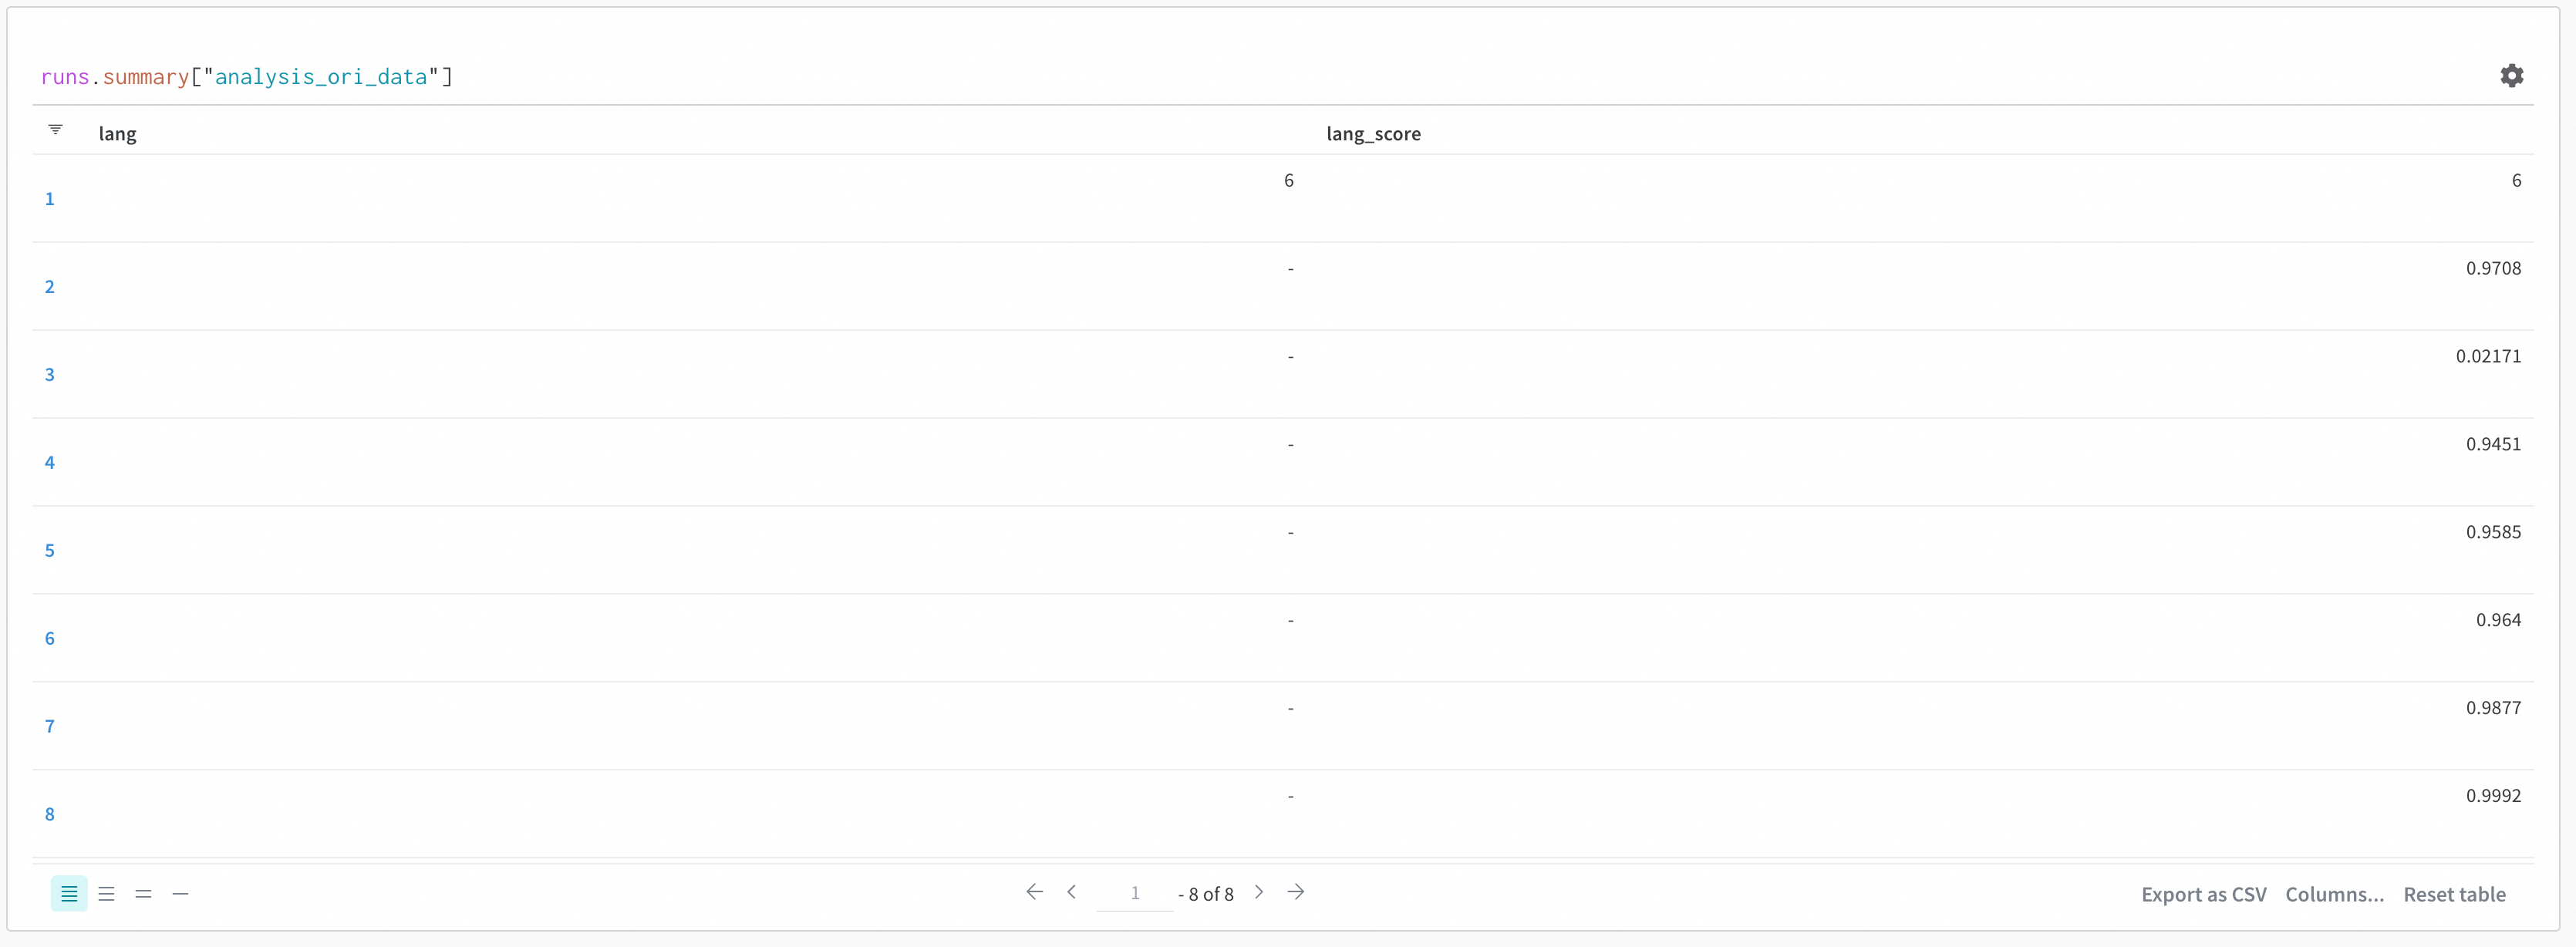

training procedures & evaluation results:

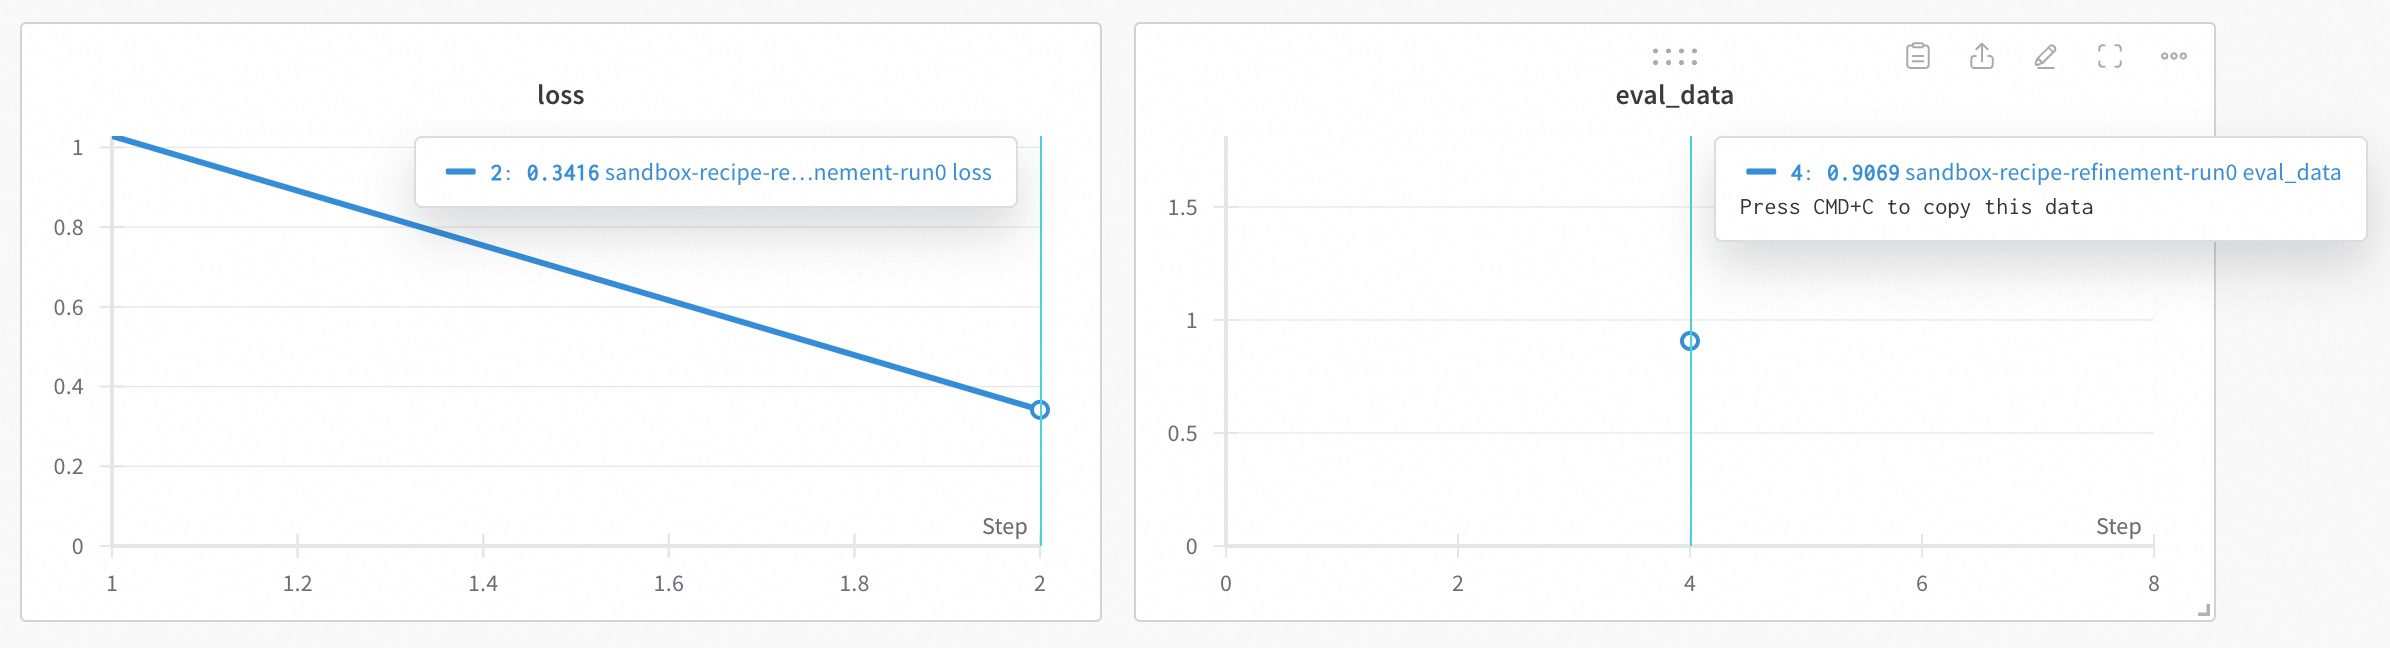

and other detailed runtime information. Users could trace the whole pipeline according to these records.

Finally, we can clean up these demo config files.

In [6]:
!rm sandbox_pipeline.yaml
!rm dj_process.yaml
!rm gpt3_extra_train_config.yaml
!rm gpt3_data_quality_eval_config.yaml

# Conclusion

In this notebook, we learn the basic usage of Data-Juicer sandbox, the default one-trial pipeline in sandbox and how to start to run a typical sandbox pipeline with config files of different components.